# Effect of Removing Matched Normal on Gene P-values

To test the robustness of the model, we explore the assocation between the model weight assigned to a particular normal tissue in the background for a sample and how removing that tissue effects the generated p-values.

In [1]:
import os
import pandas as pd
from scipy.stats import pearsonr


class MatchRemove:
    def __init__(self, background_path):
        self.df = self._load_df(background_path)

    @staticmethod
    def _load_df(path):
        """Loads DataFrame"""
        print(f"Reading in {path}")
        if path.endswith(".csv"):
            df = pd.read_csv(path, index_col=0)
        elif path.endswith(".tsv"):
            df = pd.read_csv(path, sep="\t", index_col=0)
        else:
            try:
                df = pd.read_hdf(path)
            except Exception as e:
                print(e)
                raise RuntimeError(f"Failed to open DataFrame: {path}")
        return df

    def create_backgrounds(self, tissues, out_dir):
        for tissue in tissues:
            sub = self.df[self.df.tissue != tissue]
            out = os.path.join(out_dir, f"gtex-{tissue}-removed.hd5")
            sub.to_hdf(out, key="exp")

    def manifest(self, samples, sample_path, background_dir, out_dir):
        df = self._load_df(sample_path)
        tissues = df.tissue
        out_dir = os.path.join(out_dir, "manifest.tsv")
        with open(out_dir, "w") as f:
            f.write("sample\tbackground\n")
            for sample in samples:
                tissue = tissues.loc[sample]
                bg_path = os.path.join(background_dir, f"gtex-{tissue}-removed.hd5")
                f.write(f"{sample}\t{bg_path}\n")

    @staticmethod
    def weight_pearsonR_df(out_dir, mr_dir, sample_path):
        samples = os.listdir(mr_dir)
        df = MatchRemove._load_df(sample_path)
        tissues = df.tissue
        rows = []
        for sample in samples:
            tissue = tissues.loc[sample]
            # Collect median weight
            weight_path = os.path.join(out_dir, sample, "weights.tsv")
            weights = pd.read_csv(weight_path, sep="\t", index_col=0)
            try:
                w = weights.loc[tissue].Median
            except KeyError:
                w = 0
            # Collect pvals and calculate PearsonR
            norm_path = os.path.join(out_dir, sample, "pvals.tsv")
            norm_pvals = pd.read_csv(norm_path, sep="\t", index_col=0)
            mr_path = os.path.join(mr_dir, sample, "pvals.tsv")
            mr_pvals = pd.read_csv(mr_path, sep="\t", index_col=0)
            pvals = pd.concat([norm_pvals, mr_pvals], axis=1).dropna()
            pvals.columns = ["norm", "mr"]
            r, _ = pearsonr(pvals["norm"], pvals["mr"])
            rows.append([w, r, tissue, sample])
        columns = ["Weight", "PearsonR", "Tissue", "Sample"]
        return pd.DataFrame(rows, columns=columns)


In [2]:
m = MatchRemove('/mnt/data/outlier/gtex.hd5')

Reading in /mnt/data/outlier/gtex.hd5


## Create Background Dataset for Every Tissue

This background dataset will have all samples belonging to a particular tissue removed

In [ ]:
tissues = ["Adrenal", "Bladder", "Brain", "Breast", "Kidney", 
           "Liver", "Lung", "Prostate", "Stomach", "Thyroid"]
background_dir = '/mnt/data/outlier/match-remove'
m.create_backgrounds(tissues, background_dir)

## Create Manifest for Samples

Manifest will associate a sample with the appropriate background dataset that has its matched tissue in GTEx removed

In [ ]:
samples = os.listdir('/mnt/normsd-outlier-runs/gtex-1000/')
m.manifest(
    samples=samples,
    sample_path='/mnt/data/outlier/tumor.hd5',
    background_dir=background_dir,
    out_dir='/mnt/data/outlier/match-remove/'
)

## Run Samples 

```
#!/usr/bin/env bash
source activate toil
python /mnt/gene-outlier-detection/toil/toil-outlier-detection.py \
    --sample /mnt/data/outlier/tumor.hd5 \
    --background /mnt/data/outlier/gtex.hd5 \
    --gene-list /mnt/data/outlier/drug-genes.txt \
    --manifest /mnt/normsd-outlier-runs/variable-backgrounds/manifest.tsv \
    --out-dir /mnt/normsd-outlier-runs/variable-backgrounds/output/ \
    --group tissue \
    --col-skip 5 \
    --num-backgrounds 1 \
    --max-genes 105 \
    --workDir /mnt/ \
    --disable-iter \
    /mnt/jobStore
```

## Calculate Pearson Correlations 

In [3]:
out_dir = '/mnt/normsd-outlier-runs/gtex-1000/'
mr_dir = '/mnt/normsd-outlier-runs/gtex-1000-match-removed/'
sample_path = '/mnt/data/outlier/tumor.hd5'

df = m.weight_pearsonR_df(
    out_dir=out_dir,
    mr_dir=mr_dir,
    sample_path=sample_path
)
df = df.sort_values('Tissue')
df.head()

Reading in /mnt/data/outlier/tumor.hd5


,Weight,PearsonR,Tissue,Sample
394,0.939996,0.699236,Adrenal,TCGA-OR-A5JR-01
125,0.935275,0.776023,Adrenal,TCGA-OR-A5KW-01
632,0.970991,0.611433,Adrenal,TCGA-PK-A5H9-01
635,0.961370,0.783986,Adrenal,TCGA-PK-A5HB-01
127,0.897582,0.723726,Adrenal,TCGA-OR-A5K8-01


## Plot Weight by PearsonR

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.25)
sns.set_style('whitegrid')

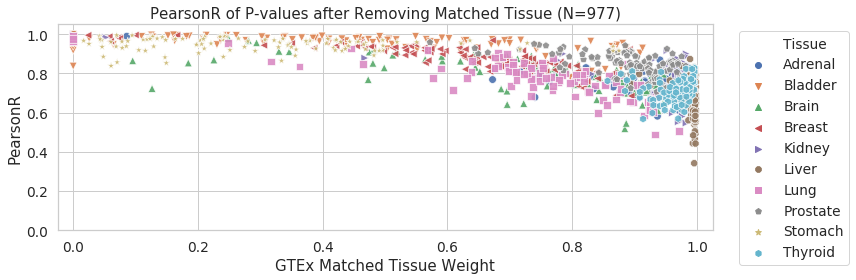

In [5]:
plt.figure(figsize=(12, 4))
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd')
sns.scatterplot(
    data=df,
    x='Weight',
    y='PearsonR',
    hue='Tissue',
    style='Tissue',
    markers=filled_markers,
    alpha=0.9,
    s=60
)
plt.title(f'PearsonR of P-values after Removing Matched Tissue (N={len(df)})')
plt.xlabel('GTEx Matched Tissue Weight')
plt.ylim([0, 1.05])
plt.xlim([-0.025, 1.025])
plt.legend(bbox_to_anchor=(1.03, 1));
plt.tight_layout()
plt.savefig(
    '/mnt/figures/match-remove/weight-pearson.png',
    dpi=300, 
    transparent=True
)